# LightWin compensation example

This notebook showcases how to compensate for a single failure.

## Imports

In [1]:
# This is only to import packaged data file
# See also: https://learn.scientific-python.org/development/patterns/data-files/
from importlib import resources
from pprint import pprint

# Actual mandatory imports for LightWin
from lightwin.config_manager import process_config
from lightwin.ui.workflow_setup import run_simulation

/home/placais/LightWin/venv/lib/python3.12/site-packages/pymoo/core/decision_making.py:2: DeprecationWarning: Please import `cKDTree` from the `scipy.spatial` namespace; the `scipy.spatial.ckdtree` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.spatial.ckdtree import cKDTree


## Presentation of the linac

The structure of the linac is stored in a `DAT` file.
It follows the same specifications as TraceWin structure file, see [associated help page](../usage.compatibility_with_tracewin.rst) for more information.
The example can be found in `data/ads/ads.dat` (or `src/lightwin/data/ads/ads.dat` if you built LightWin from source).
Here are the first lines of the file:

In [2]:
dat_res = resources.files("lightwin.data.ads") / "ads.dat"
dat_content = dat_res.read_text(encoding="utf-8")
print(dat_content[:892])

;------------------------------------
; TraceWin Version: 2.23.1.3
; OS: Win10 (64-bit)
; Date: Fri Oct 20 14:31:57 2023
; User: FBOULY
; Computer: LPSC5003W
;------------------------------------

FIELD_MAP_PATH field_maps_1D


; Section #1

LATTICE 10 0
FREQ 352.2
; Lattice #1
QUAD 200 5.66763 100 0 0 0 0 0 0
DRIFT 150 100 0 0 0
QUAD 200 -5.67474 100 0 0 0 0 0 0
DRIFT 150 100 0 0 0
DRIFT 589.42 30 0 0 0
FIELD_MAP 100 415.16 153.171 30 0 1.55425 0 0 Simple_Spoke_1D 0
DRIFT 264.84 30 0 0 0
FIELD_MAP 100 415.16 156.892 30 0 1.55425 0 0 Simple_Spoke_1D 0
DRIFT 505.42 30 0 0 0
DRIFT 150 100 0 0 0
; Lattice #2
QUAD 200 5.77341 100 0 0 0 0 0 0
DRIFT 150 100 0 0 0
QUAD 200 -5.77854 100 0 0 0 0 0 0
DRIFT 150 100 0 0 0
DRIFT 589.42 30 0 0 0
FIELD_MAP 100 415.16 161.635 30 0 1.56423 0 0 Simple_Spoke_1D 0
DRIFT 264.84 30 0 0 0
FIELD_MAP 100 415.16 165.455 30 0 1.56423 0 0 Simple_Spoke_1D 0



This is a high-power, ADS-like proton acceleractor characterized by a very high longitudinal acceptance.

## Configuration of LightWin

In order to ensure reproducibility and portability of results, all the configuration is set in a `TOML` configuration.
The full specifications are listed in [Configuration](../configuration.rst).

In [3]:
toml_filepath = resources.files("lightwin.data.ads") / "lightwin.toml"  # Or provide Path to TOML file

Below, we associate LightWin's configuration objects with sections in the `TOML` file (the names between brackets).

In [4]:
toml_keys = {
    "files": "files",
    "beam": "beam",
    "beam_calculator": "generic_envelope1d",
    "wtf": "generic_wtf",
    "design_space": "fit_phi_s_design_space",
    "plots": "plots_minimal",
}

This operation will check validity of the configuration, resolve paths, and  convert the `TOML` appropriate entries to a dictionary.

In [13]:
# Adapt some configuration entries for this notebook
override = {
    "beam_calculator": {
        "flag_cython": True,  # Override flag_cython=False in [generic_envelope1d]
    },
    "wtf": {
        "k": 5,               # Override k=3 in [generic_wtf]
    },
}
config = process_config(toml_filepath, toml_keys, override=override)

[INFO    ] [table_spec.py       ] .toml table [files] loaded!
[INFO    ] [table_spec.py       ] .toml table [beam] loaded!
[INFO    ] [table_spec.py       ] .toml table [generic_envelope1d] loaded!
[INFO    ] [table_spec.py       ] .toml table [plots_minimal] loaded!
[INFO    ] [table_spec.py       ] .toml table [fit_phi_s_design_space] loaded!
[INFO    ] [table_spec.py       ] .toml table [generic_wtf] loaded!
[INFO    ] [log_manager.py      ] Starting log for LightWin - Version: 0.9.0, Commit: 83175805808cf27ec1b2f201ca16cef8bb20d9f3
[INFO    ] [files_specs.py      ] Setting project_path = PosixPath('/home/placais/LightWin/src/lightwin/data/ads/lw_results')
Setting log_file = 'lightwin.log'


### `files` ([doc](../configuration.files.rst))

Defines the files to use, as well as where results should be saved.

In [6]:
pprint(config["files"])

{'dat_file': PosixPath('/home/placais/LightWin/src/lightwin/data/ads/ads.dat'),
 'project_folder': PosixPath('/home/placais/LightWin/src/lightwin/data/ads/lw_results')}


### `beam` ([doc](../configuration.beam.rst))

Define the beam properties.

In [7]:
pprint(config["beam"])

{'e_mev': 20.0,
 'e_rest_mev': 938.27203,
 'f_bunch_mhz': 100.0,
 'gamma_init': 1.021315779817075,
 'i_milli_a': 0.0,
 'inv_e_rest_mev': 0.0010657889908537506,
 'lambda_bunch': 2997924.58,
 'm_over_q': 938.27203,
 'omega_0_bunch': 628318530.7179586,
 'q_adim': 1.0,
 'q_over_m': 0.0010657889908537506,
 'sigma': array([[ 8.409896e-06,  3.548736e-06,  0.000000e+00,  0.000000e+00,
         0.000000e+00,  0.000000e+00],
       [ 3.548736e-06,  1.607857e-06,  0.000000e+00,  0.000000e+00,
         0.000000e+00,  0.000000e+00],
       [ 0.000000e+00,  0.000000e+00,  2.941564e-06,  6.094860e-07,
         0.000000e+00,  0.000000e+00],
       [ 0.000000e+00,  0.000000e+00,  6.094860e-07,  4.418911e-07,
         0.000000e+00,  0.000000e+00],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
         3.593136e-06, -2.552518e-07],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        -2.552518e-07,  5.994771e-07]])}


### `beam_calculator`([doc](../configuration.beam_calculator.rst))

Define how the propagation of the beam in the linac will be calculated.
Note that you can define a `beam_calculator_post` in a similar fashion; it will be used to re-compute the propagation of the beam once the compensation settings are found.

In [8]:
pprint(config["beam_calculator"])

{'export_phase': 'phi_0_abs',
 'flag_cython': False,
 'flag_phi_abs': True,
 'method': 'RK4',
 'n_steps_per_cell': 40,
 'tool': 'Envelope1D'}


### `plots` ([doc](../configuration.plots.rst))

Define the plots to create at the end of the simulation.

In [9]:
pprint(config["plots"])

{'add_objectives': True,
 'cav': True,
 'emittance': False,
 'energy': True,
 'envelopes': False,
 'phase': True,
 'transfer_matrices': False,
 'twiss': True}


### `wtf` ([doc](../configuration.wtf.rst))

Stands for "what to fit".

In [14]:
pprint(config["wtf"])

{'failed': [['FM11']],
 'id_nature': 'name',
 'k': 5,
 'objective_preset': 'EnergyPhaseMismatch',
 'optimisation_algorithm': 'downhill_simplex',
 'optimisation_algorithm_kwargs': {'options': {'adaptive': True,
                                               'disp': False}},
 'strategy': 'k out of n'}


### `design_space` ([doc](../configuration.design_space.rst))

Defines the design space, *i.e.* the optimization variables and their bounds.

In [11]:
pprint(config["design_space"])

{'design_space_preset': 'sync_phase_amplitude',
 'from_file': False,
 'max_absolute_sync_phase_in_deg': 0.0,
 'max_decrease_k_e_in_percent': 20.0,
 'max_increase_k_e_in_percent': 180.0,
 'max_increase_sync_phase_in_percent': 40.0,
 'maximum_k_e_is_calculated_wrt_maximum_k_e_of_section': True,
 'min_absolute_sync_phase_in_deg': -90.0}


## Actual usage

[INFO    ] [factory.py          ] First initialisation of ListOfElements, ecompassing all linac. Created with dat_file = PosixPath('/home/placais/LightWin/src/lightwin/data/ads/ads.dat')
[INFO    ] [list_of_elements.py ] Successfully created a ListOfElements with self.w_kin_in = 20.0 MeV and self.phi_abs_in = 0.0 rad.
[WARNING ] [factory.py          ] You asked LW a simulation in absolute phase, while there is at least one cavity in relative phase in the .dat file used by TW. You can expect a phase difference between LightWin results and TraceWin results for the same input .dat, after the first failed cavity. No difference should appear with the output .dat, or when using TraceWin solver within LightWin.
[INFO    ] [factory.py          ] First initialisation of ListOfElements, ecompassing all linac. Created with dat_file = PosixPath('/home/placais/LightWin/src/lightwin/data/ads/ads.dat')
[INFO    ] [list_of_elements.py ] Successfully created a ListOfElements with self.w_kin_in = 20.0 M

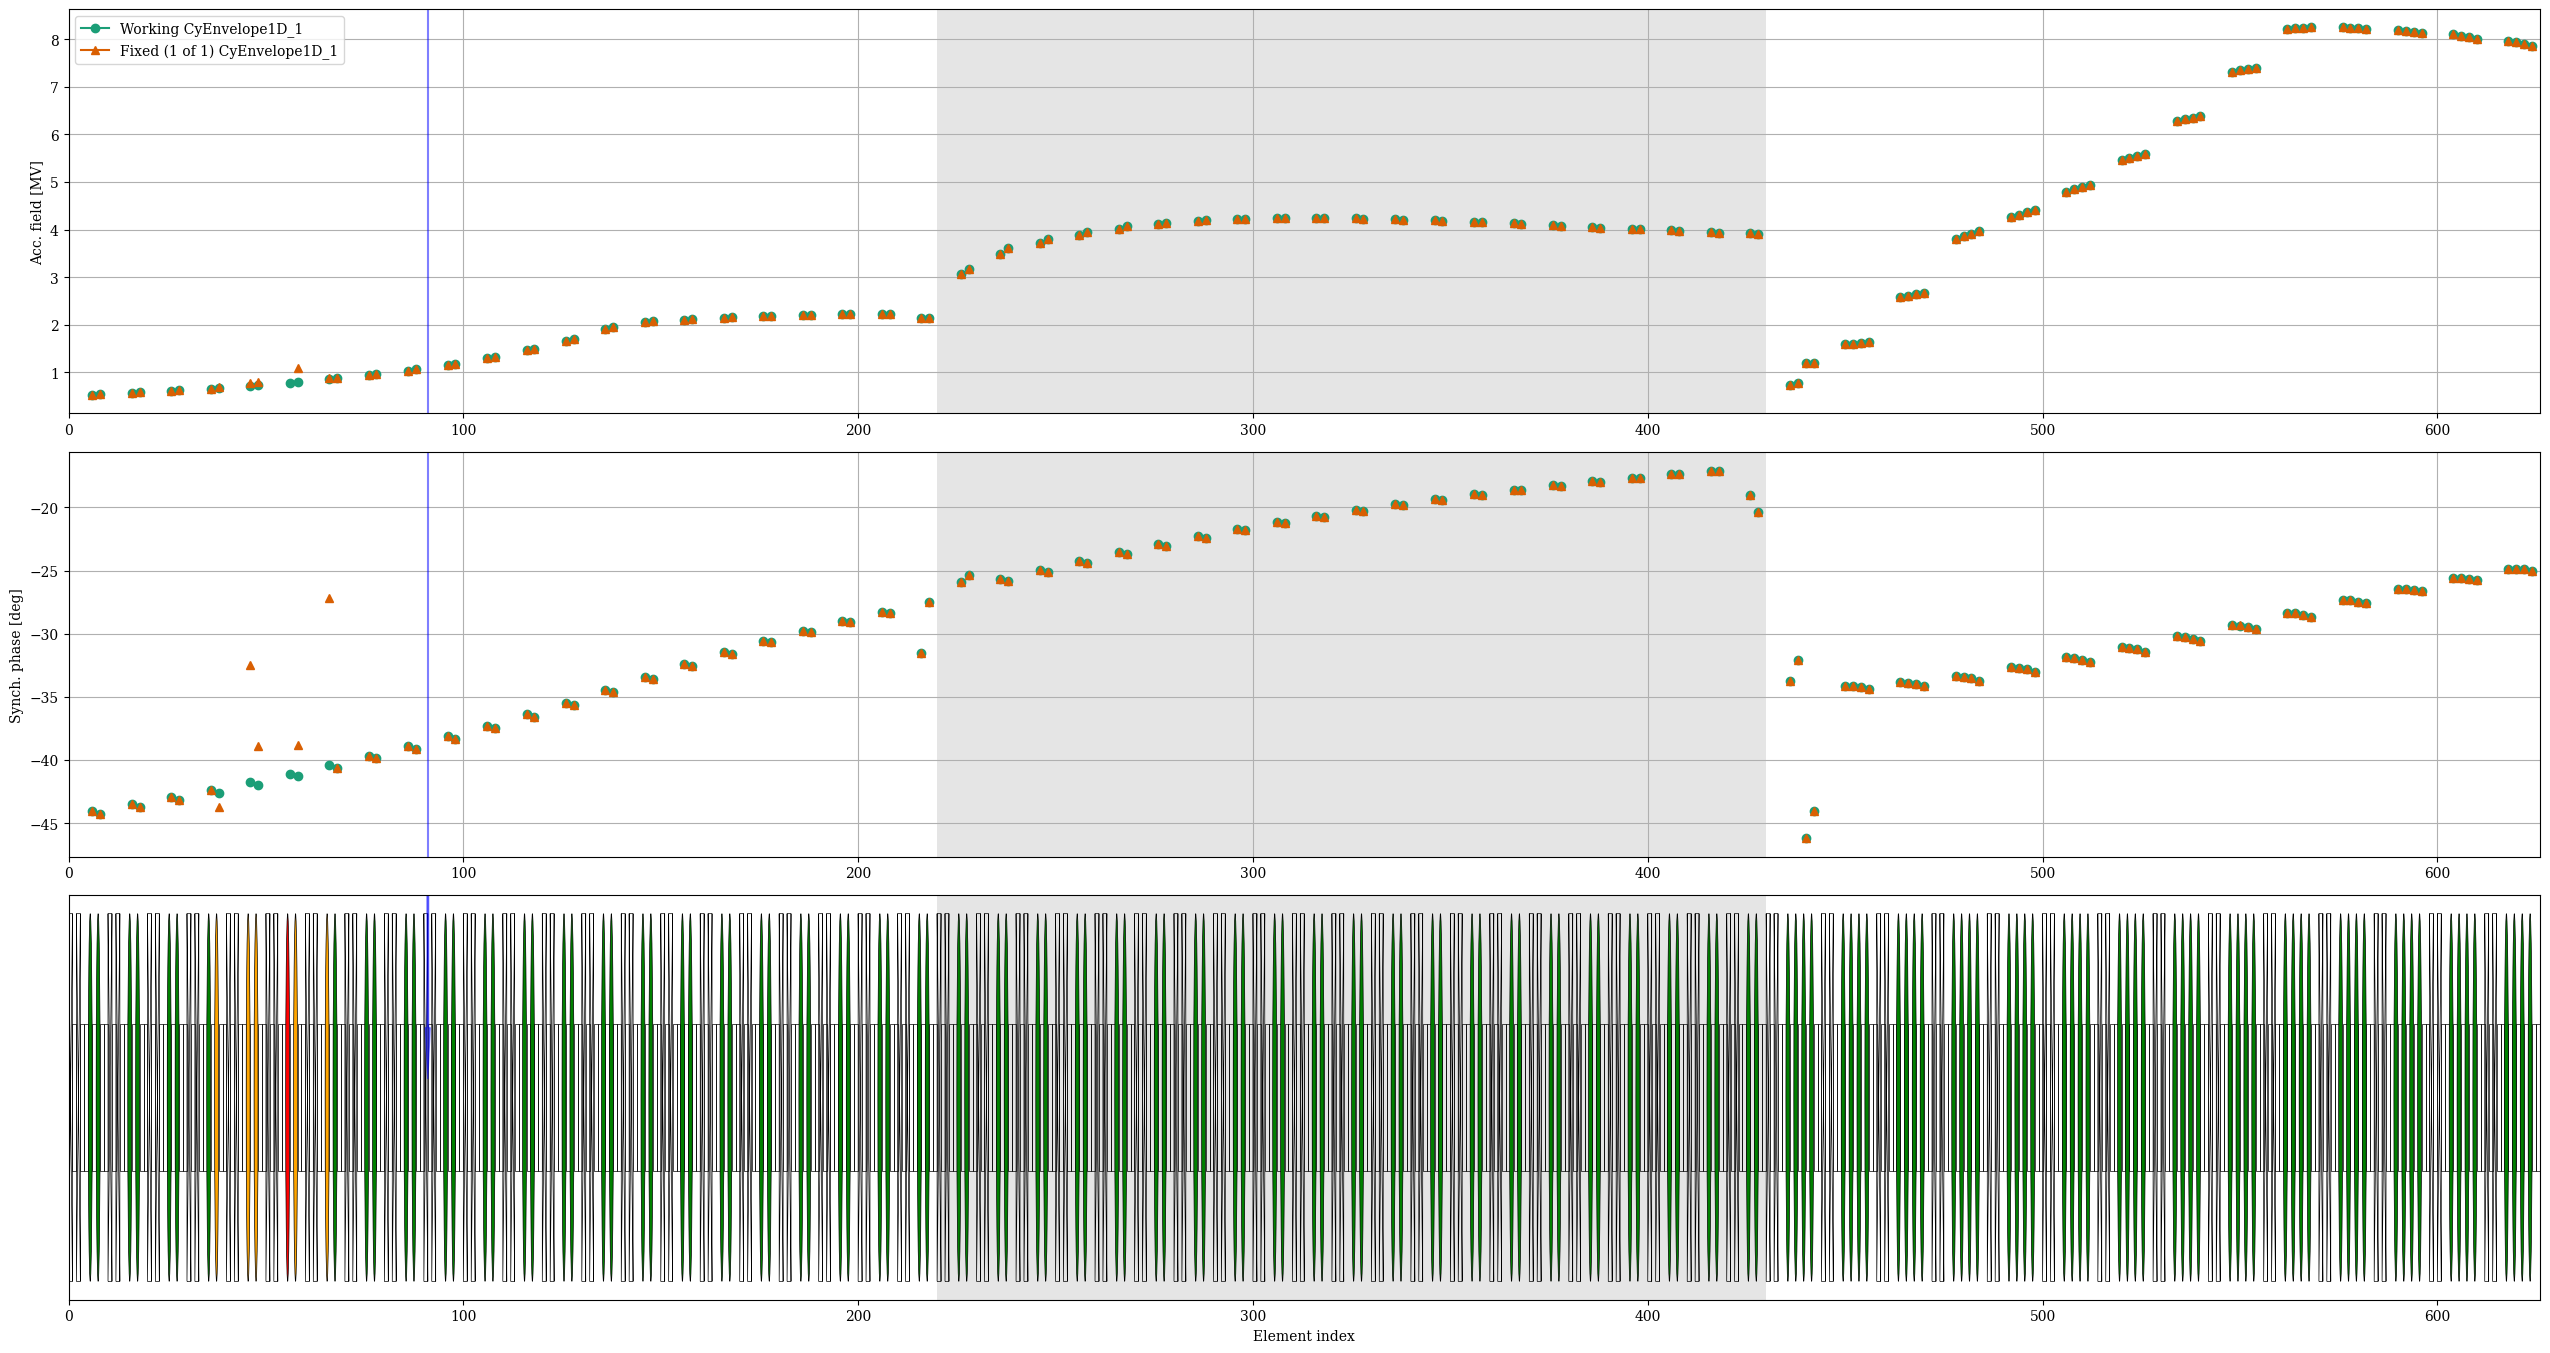

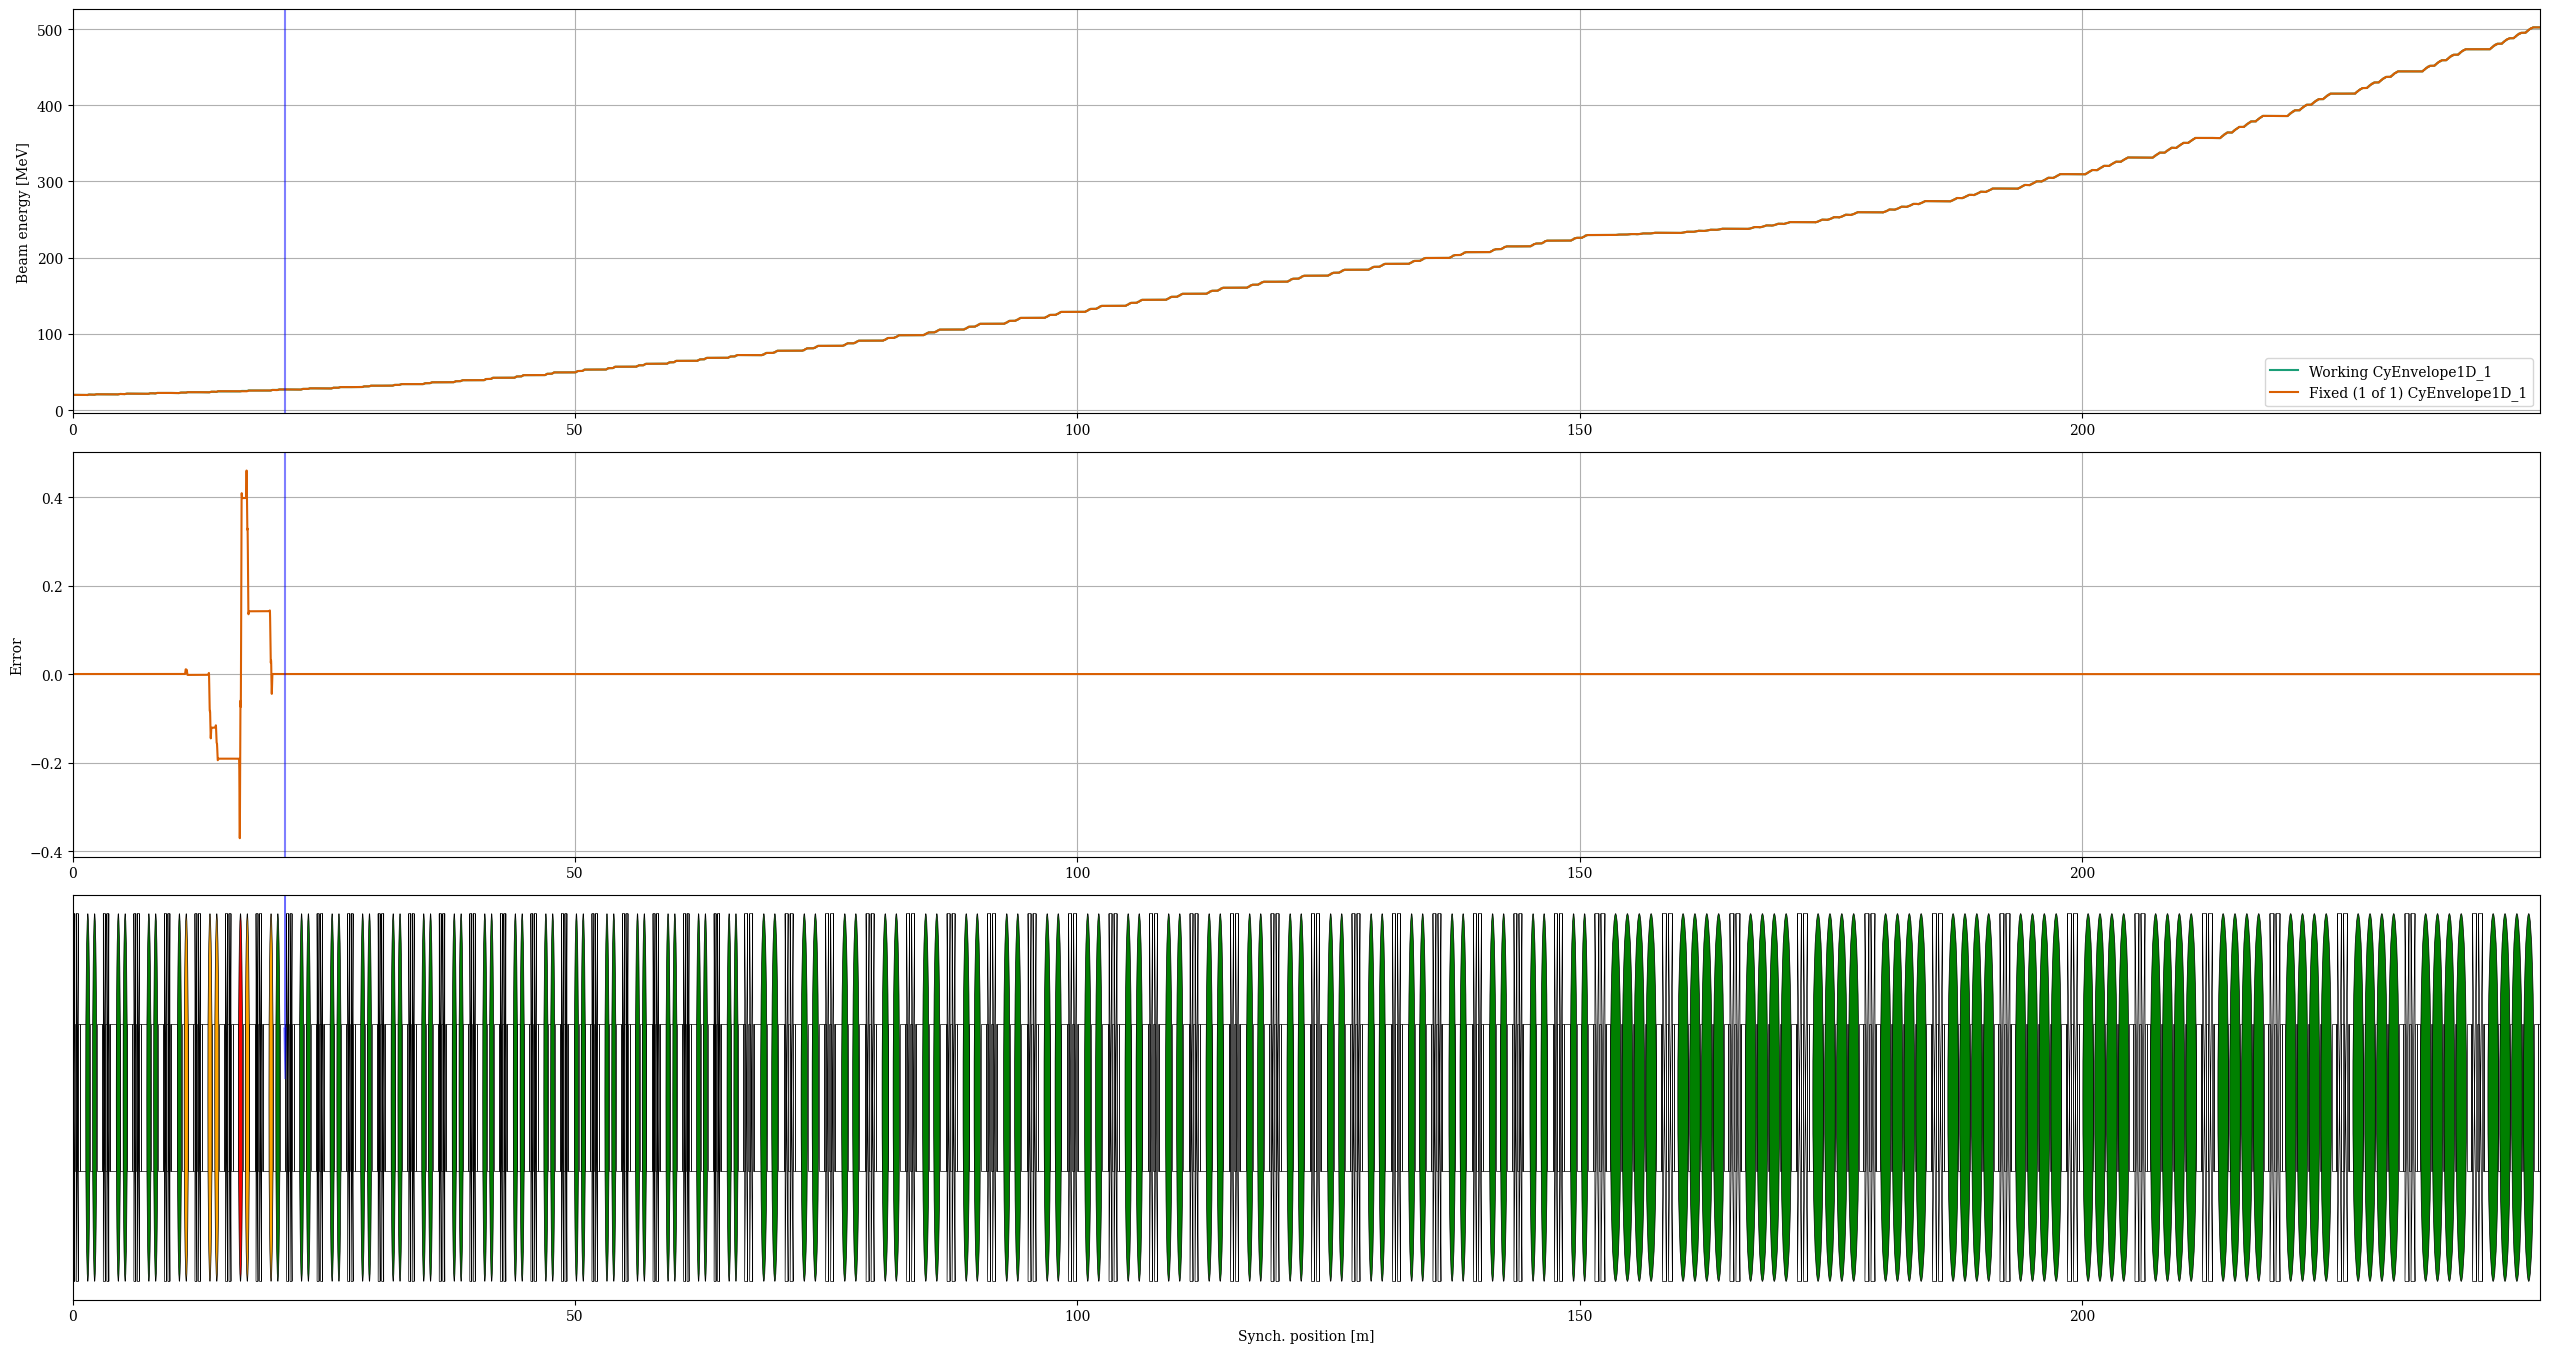

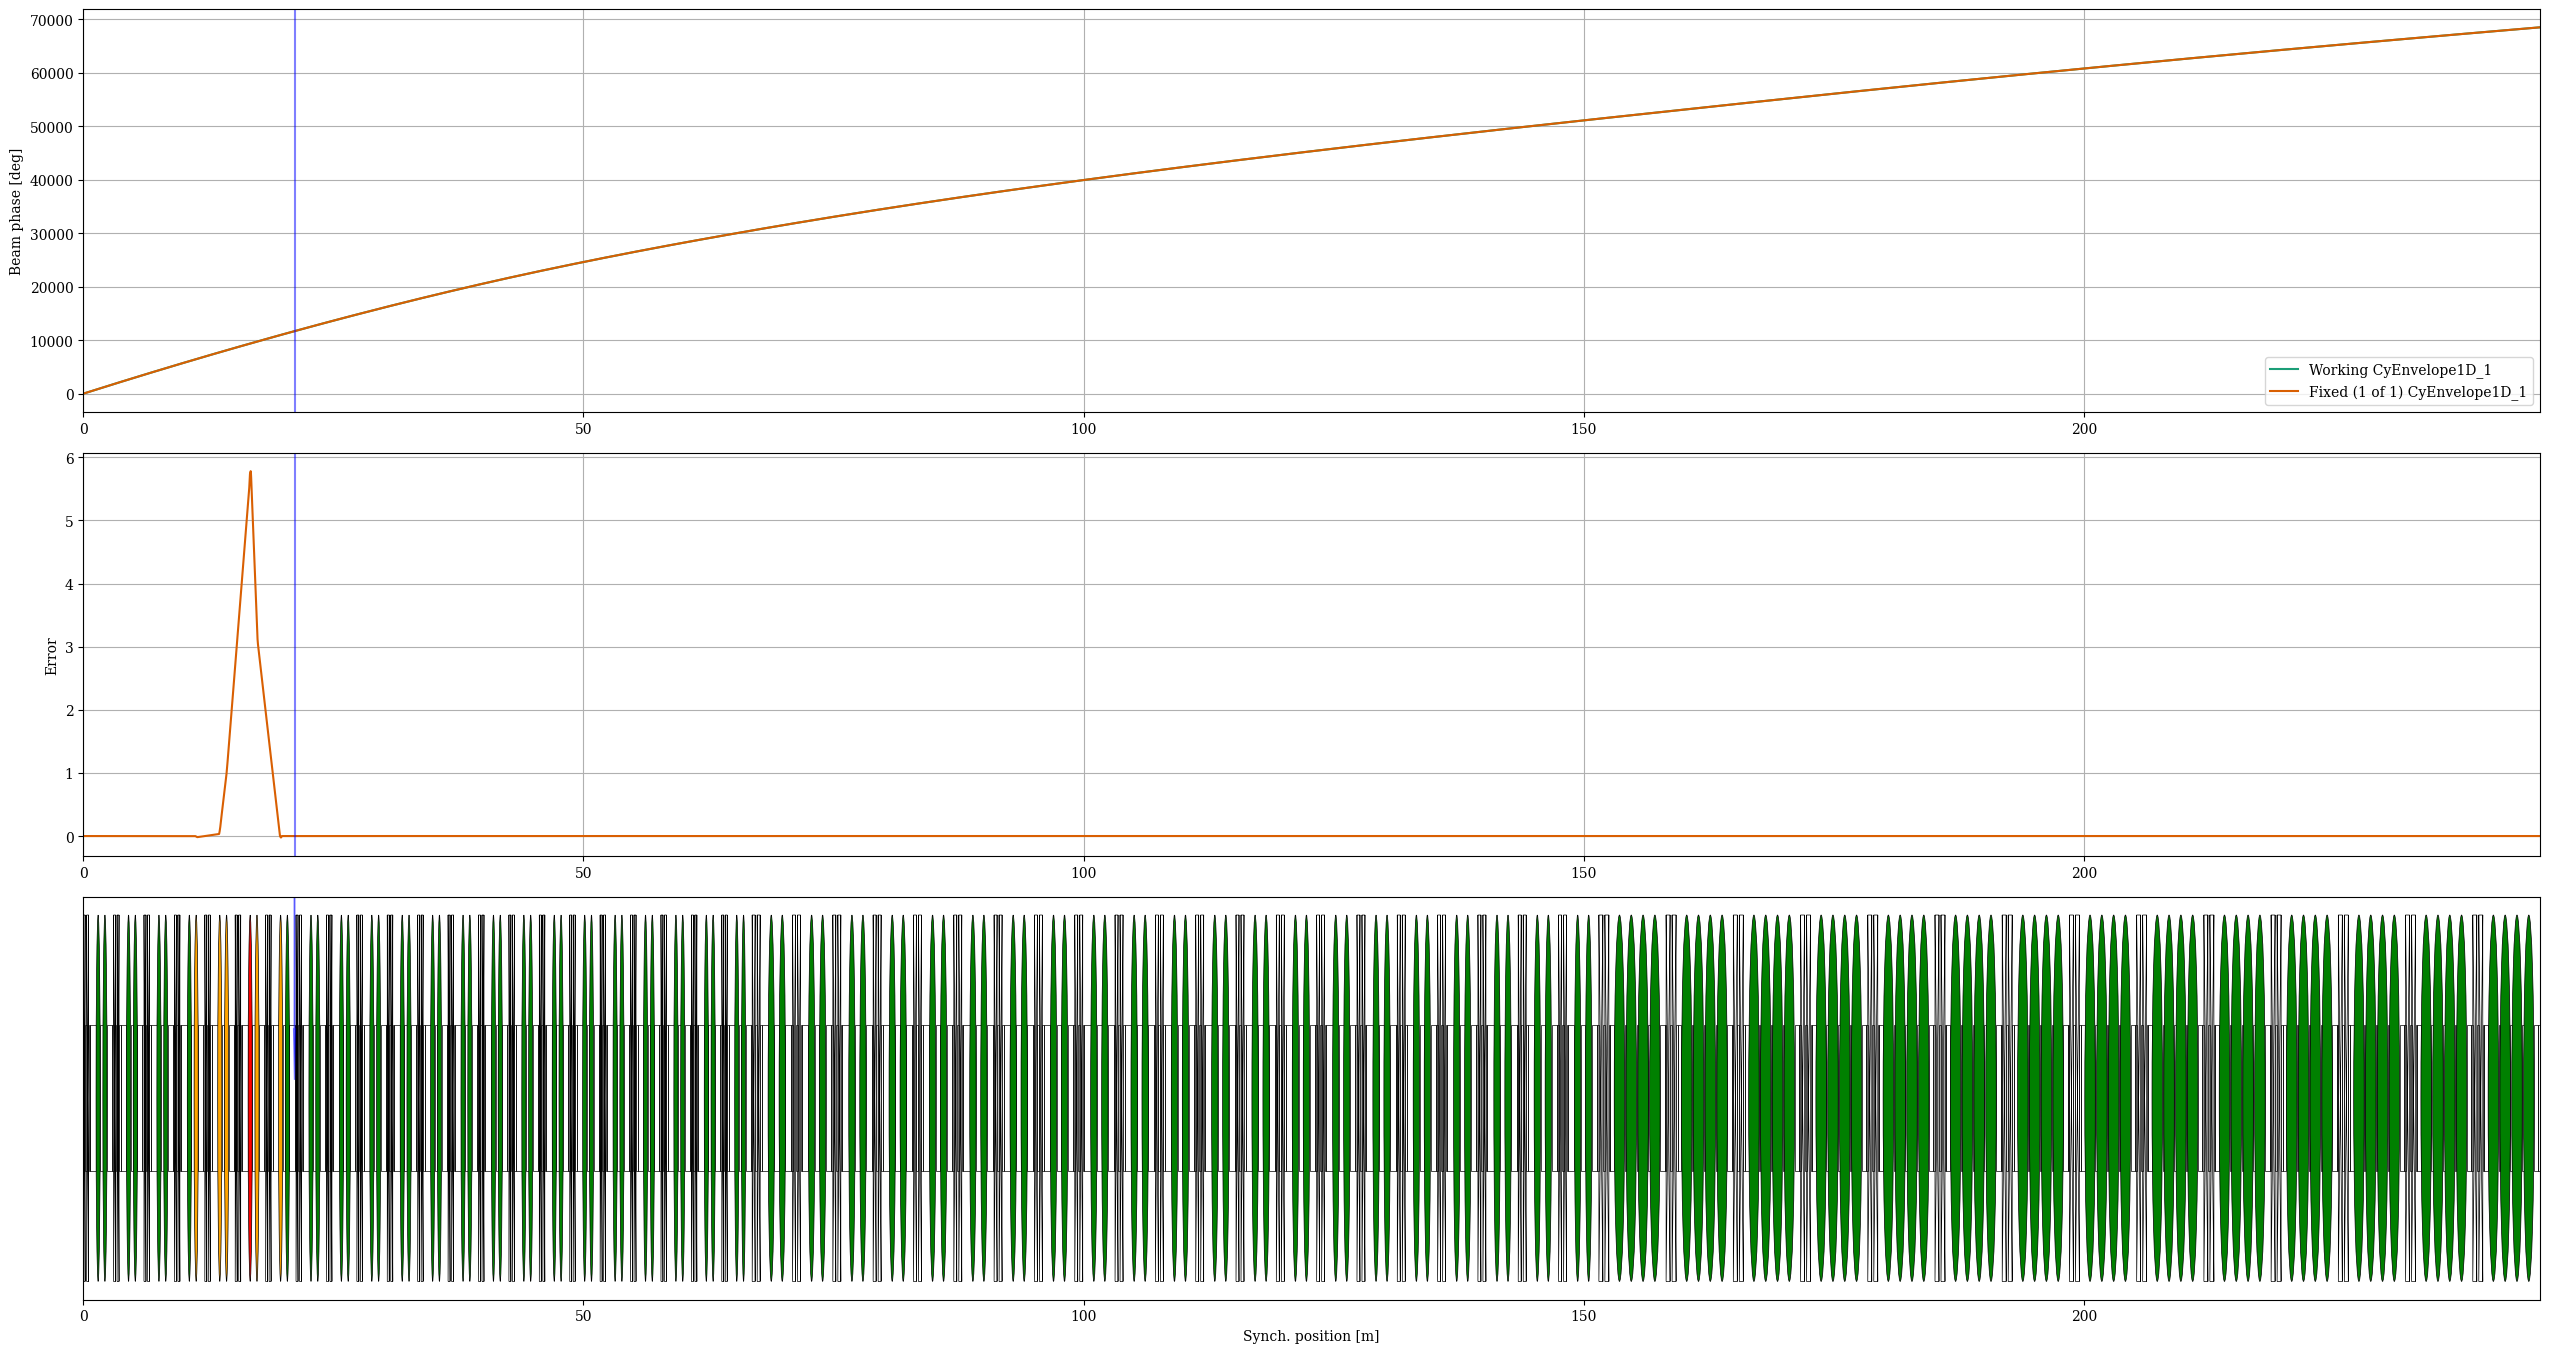

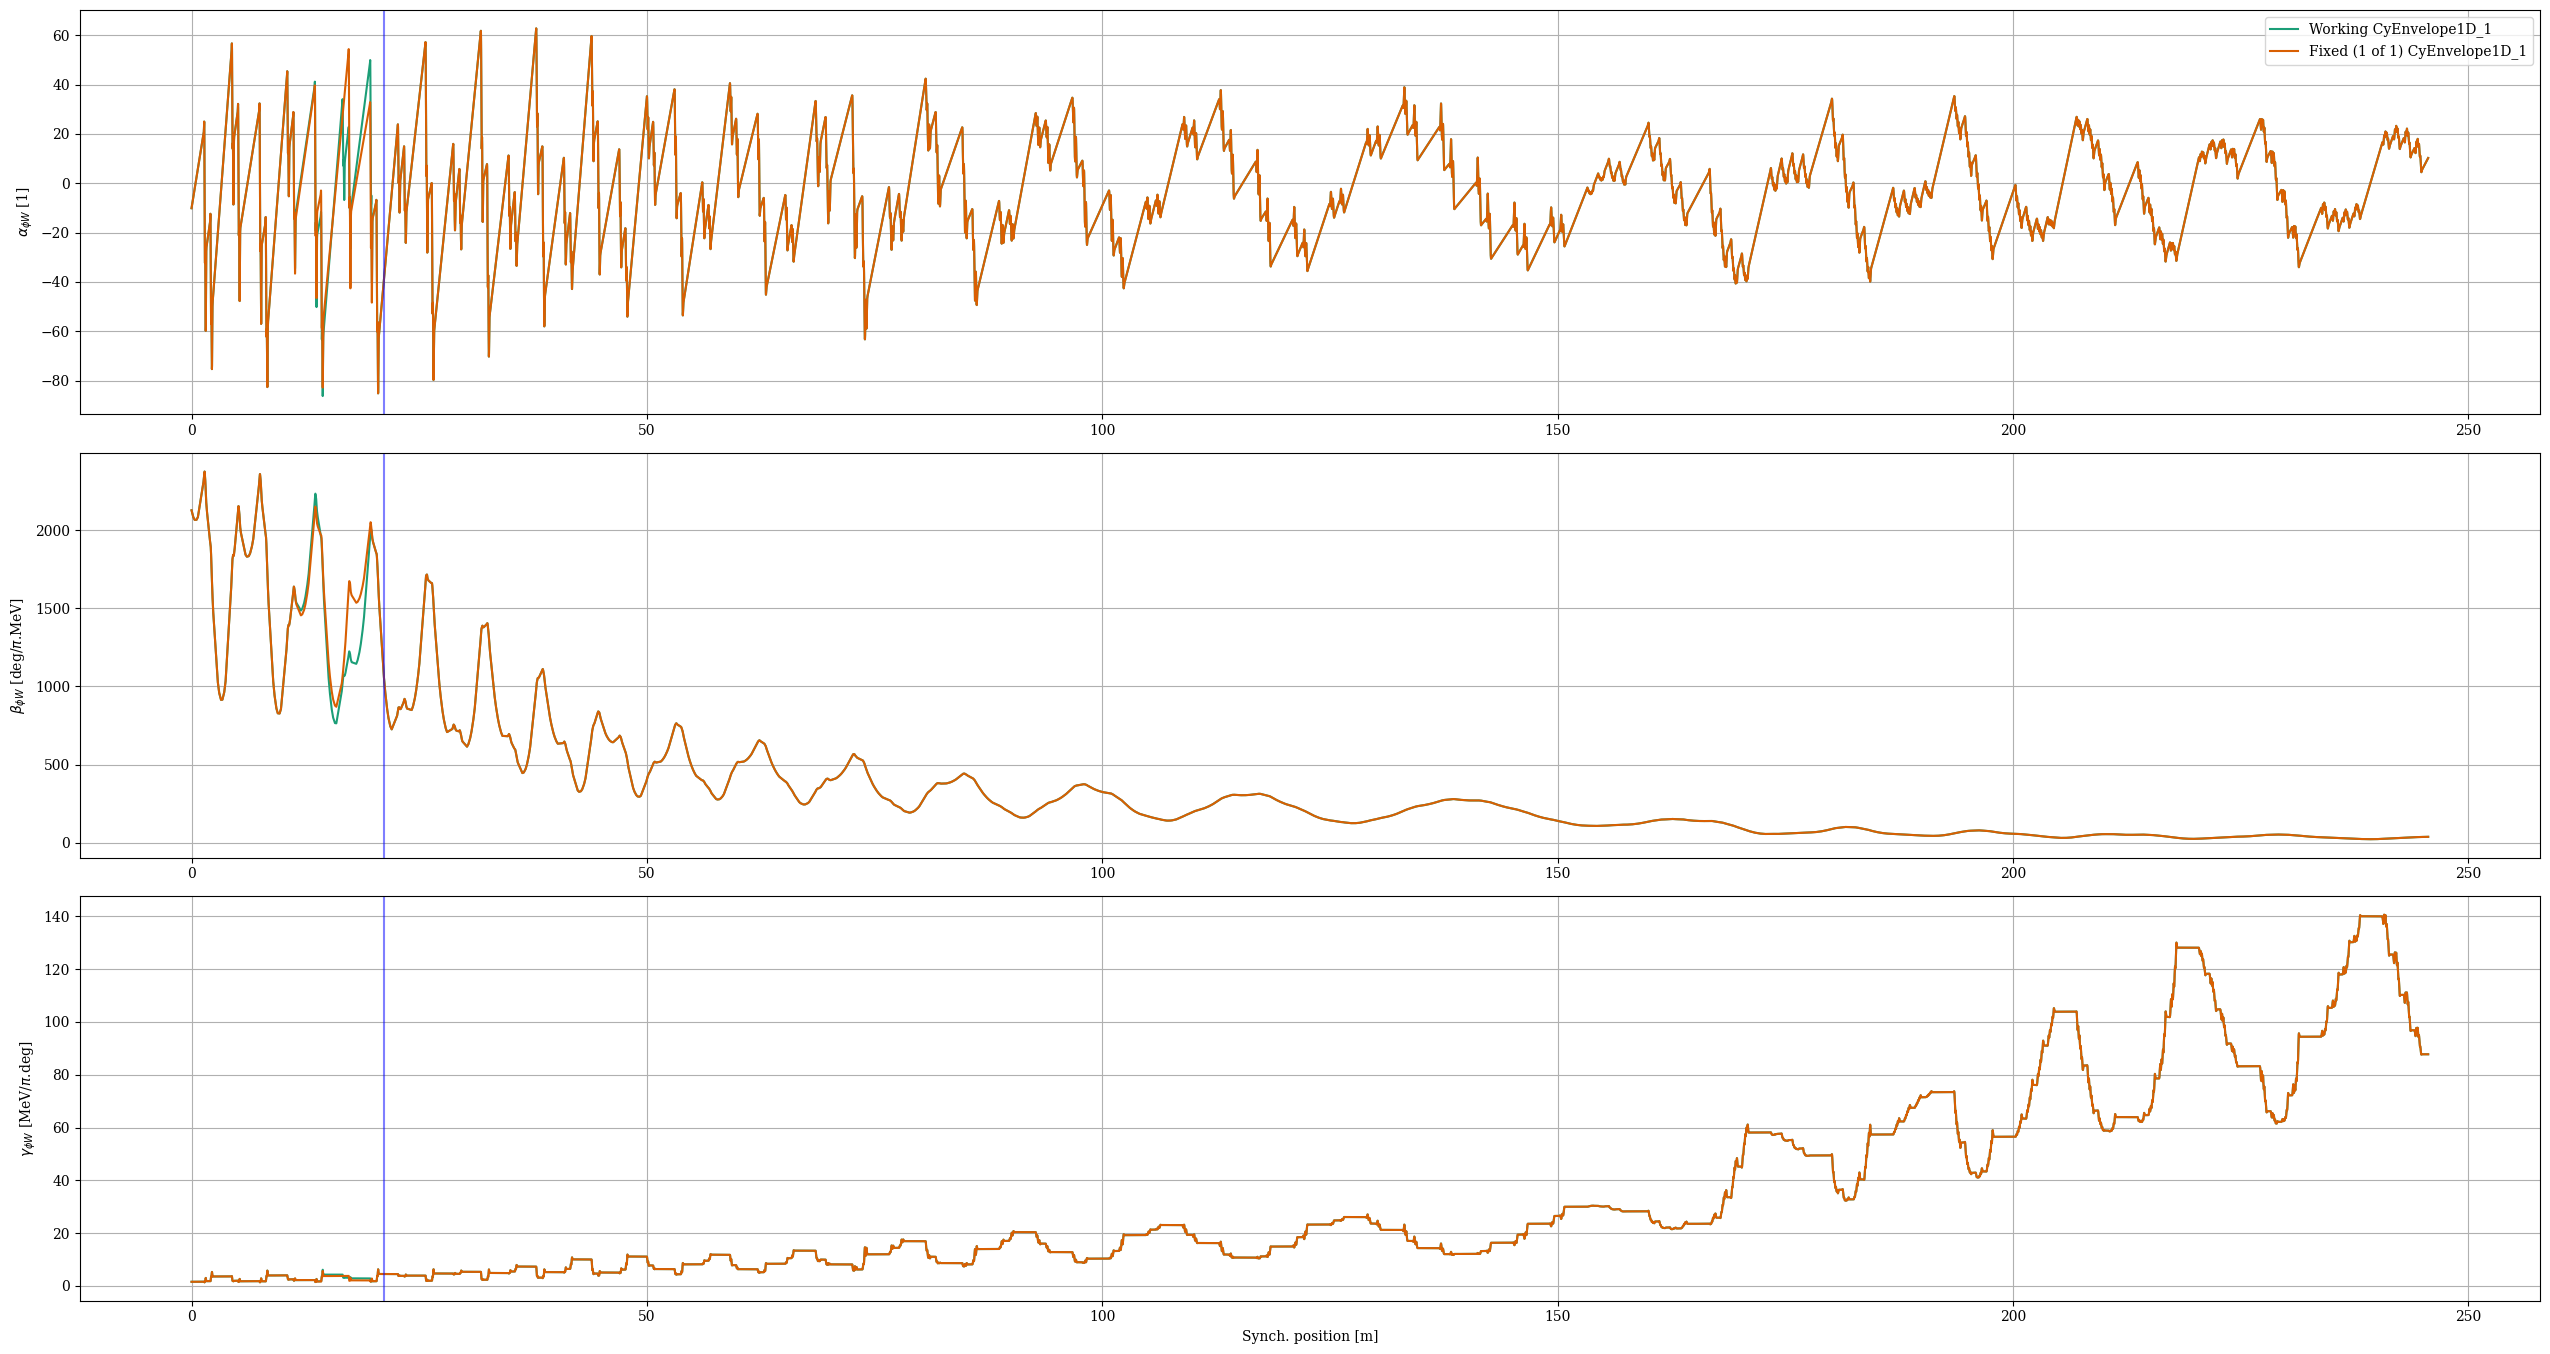

In [15]:
fault_scenarios = run_simulation(config)